In [1]:
pip install mesa numpy matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 415.7 kB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 371.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.7/425.7 kB 7.6 MB/s eta 0:

In [2]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from mesa import Model, Agent
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from IPython.display import HTML, display
import io
from PIL import Image
import pickle

In [3]:
class BirdAgent(Agent):
    def __init__(self, unique_id, model, initial_state, age_group):
        super().__init__(unique_id, model)
        self.state = initial_state  # Initial health state of the bird (S, E, I, R, or D)
        self.age_group = age_group  # Age group of the bird (young or adult)
        self.set_parameters_by_age(age_group)  # Set age-specific parameters
        self.immunity = 0  # Current immunity level
        self.infection_time = 0  # Time when the bird was infected

    def set_parameters_by_age(self, age_group):
        # Set different parameters based on the bird's age group
        if age_group == 'young':
            self.incubation_period = 1  # Shorter incubation for young birds
            self.infection_period = 8  # Longer infection period for young birds
            self.base_transmission_rate = 0.95  # Higher transmission rate for young birds
            self.base_mortality_rate = 0.02  # Higher mortality rate for young birds
            self.immunity_duration = 2  # Shorter immunity duration for young birds
        else:  # adult
            self.incubation_period = 2  # Longer incubation for adult birds
            self.infection_period = 7  # Slightly shorter infection period for adult birds
            self.base_transmission_rate = 0.9  # Lower transmission rate for adult birds
            self.base_mortality_rate = 0.01  # Lower mortality rate for adult birds
            self.immunity_duration = 4  # Longer immunity duration for adult birds

    def get_adjusted_transmission_rate(self):
        # Calculate adjusted transmission rate based on environmental factors
        temp_factor = 1 + (self.model.temperature - 25) * 0.04  # Temperature impact
        hygiene_factor = 1 - self.model.hygiene_level * 0.5  # Hygiene impact

        # Return adjusted rate, capped at 1 to prevent unrealistic transmission rates
        return min(1, self.base_transmission_rate * temp_factor * hygiene_factor)

    def get_adjusted_mortality_rate(self):
        # Calculate adjusted mortality rate based on environmental factors
        temp_factor = 1 + abs(self.model.temperature - 25) * 0.01  # Temperature impact
        hygiene_factor = 1 - self.model.hygiene_level * 0.5  # Hygiene impact
        return self.base_mortality_rate * temp_factor * hygiene_factor

    def interact(self):
        # Skip interaction if bird is dead or recovered
        if self.state in ['D', 'R']:
            return

        # Get all birds in the same cell
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        for other in cellmates:
            # If this bird is infected and the other is susceptible, attempt transmission
            if other.state == 'S' and self.state == 'I':
                if self.random.random() < self.get_adjusted_transmission_rate():
                    other.state = 'E'  # Other bird becomes exposed
                    other.infection_time = self.model.schedule.time  # Record infection time

    def update_state(self):
        if self.state == 'D':  # No state change if bird is dead
            return

        current_time = self.model.schedule.time

        if self.state == 'E' and (current_time - self.infection_time > self.incubation_period):
            self.state = 'I'  # Exposed becomes Infected after incubation period
        elif self.state == 'I' and (current_time - self.infection_time > self.infection_period):
            if self.random.random() < self.get_adjusted_mortality_rate():
                self.state = 'D'  # Bird dies
            else:
                self.state = 'R'  # Bird recovers
                self.immunity = self.immunity_duration
        elif self.state == 'R':
            if self.immunity > 0:
                self.immunity -= 1  # Decrease immunity duration
            else:
                self.state = 'S'  # Bird becomes susceptible again after immunity wears off

    def step(self):
        self.move()  # Move to a new position
        self.interact()  # Interact with other birds
        self.update_state()  # Update health state

    def move(self):
        # Get all possible neighboring cells
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False)
        # Choose a random new position
        new_position = self.random.choice(possible_steps)
        # Move the bird to the new position
        self.model.grid.move_agent(self, new_position)

In [4]:
class AvianFluModel(Model):
    def __init__(self, N, width, height, initial_infected=12, temperature=30, hygiene_level=0.2):
        super().__init__()
        # Initialize model parameters
        self.num_agents = N  # Total number of bird agents
        self.grid = MultiGrid(width, height, True)  # Create a multi-grid environment
        self.schedule = RandomActivation(self)  # Use random activation for agents
        self.initial_infected = initial_infected  # Number of initially infected birds
        self.running = True  # Flag to control model execution
        self.temperature = temperature  # Initial temperature of the environment
        self.hygiene_level = hygiene_level  # Initial hygiene level
        self.initial_hygiene_level = hygiene_level  # Store initial hygiene level for reference

        # Set up data collector to track model statistics
        self.datacollector = DataCollector(
            model_reporters={
                "Susceptible": lambda m: sum(1 for a in m.schedule.agents if a.state == 'S'),
                "Infected": lambda m: sum(1 for a in m.schedule.agents if a.state == 'I'),
                "Recovered": lambda m: sum(1 for a in m.schedule.agents if a.state == 'R'),
                "Dead": lambda m: sum(1 for a in m.schedule.agents if a.state == 'D'),
                "Exposed": lambda m: sum(1 for a in m.schedule.agents if a.state == 'E'),
                "Temperature": lambda m: m.temperature,
                "Hygiene Level": lambda m: m.hygiene_level
            }
        )

        # Calculate center of the grid for initial infected placement
        center_x, center_y = self.grid.width // 2, self.grid.height // 2

        # Create and place bird agents
        for i in range(self.num_agents):
            if i < self.initial_infected:
                # Place initially infected birds near the center
                x = center_x + self.random.randrange(-1, 2)
                y = center_y + self.random.randrange(-1, 2)
                state = 'E'  # Start in exposed state
            else:
                # Place susceptible birds randomly
                x = self.random.randrange(self.grid.width)
                y = self.random.randrange(self.grid.height)
                state = 'S'  # Start in susceptible state

            # Randomly assign age group
            age_group = 'young' if self.random.random() < 0.5 else 'adult'

            # Create bird agent and add to schedule and grid
            bird = BirdAgent(i, self, state, age_group)
            self.schedule.add(bird)
            self.grid.place_agent(bird, (x, y))

    def step(self):
        # Collect data at each step
        self.datacollector.collect(self)
        # Execute all agents' step methods
        self.schedule.step()

        # Calculate the proportion of infected and exposed birds
        infected_ratio = sum(1 for a in self.schedule.agents if a.state in ['I', 'E']) / self.num_agents

        # Update temperature
        base_temp_change = self.random.uniform(-0.2, 0.2)  # Random temperature fluctuation
        infection_temp_effect = 0.5 * infected_ratio  # Temperature increase due to infections
        self.temperature += base_temp_change + infection_temp_effect
        # Ensure temperature stays within a realistic range
        self.temperature = max(20, min(40, self.temperature))

        # Update hygiene level
        hygiene_decrease = 0.05 * infected_ratio  # Hygiene decreases as infections increase
        random_factor = self.random.uniform(-0.02, 0.01)  # Small random change in hygiene
        self.hygiene_level = max(0, min(1, self.hygiene_level - hygiene_decrease + random_factor))

        # Implement basic hygiene management
        if self.hygiene_level < 0.1:
            self.hygiene_level += 0.05  # Slight improvement if hygiene is very low

        # High temperatures negatively affect hygiene
        if self.temperature > 28:
            self.hygiene_level -= 0.01

In [5]:
def animate_chicken_states(model, total_steps, save_steps=[0, 5, 10, 20, 30, 40]):
    fig, ax = plt.subplots(figsize=(7, 7))
    saved_figures = {}

    def update(frame):
        ax.clear()
        ax.set_facecolor('#fff7bc')

        if frame > 0:
            model.step()

        positions = {state: {} for state in ['S', 'I', 'E', 'R', 'D']}
        for agent in model.schedule.agents:
            if agent.pos in positions[agent.state]:
                positions[agent.state][agent.pos] += 1
            else:
                positions[agent.state][agent.pos] = 1

        colors = {'S': 'white', 'I': 'red', 'E': 'orange', 'R': 'green', 'D': 'black'}
        labels = {'S': 'Healthy', 'I': 'Infected', 'E': 'Incubation', 'R': 'Recovered', 'D': 'Dead'}

        for state, pos_dict in positions.items():
            if pos_dict:
                x, y = zip(*pos_dict.keys())
                sizes = [50 * count for count in pos_dict.values()]
                ax.scatter(x, y, c=colors[state], edgecolor='black', s=sizes, label=f"{labels[state]}: {sum(pos_dict.values())}", alpha=0.7)

        ax.set_title(f'Time Step: {frame}\nTemperature: {model.temperature:.2f}°C, Hygiene Level: {model.hygiene_level:.2f}')
        ax.legend(loc='upper right')
        ax.set_xlim(-0.5, model.grid.width - 0.5)
        ax.set_ylim(-0.5, model.grid.height - 0.5)
        ax.grid(True)

       # Add environment information
        env_info = f"Temperature: {model.temperature:.2f}°C\nHygiene Level: {model.hygiene_level:.2f}"
        ax.text(0.02, 0.98, env_info, transform=ax.transAxes, verticalalignment='top', fontsize=10)

        if frame in save_steps:
            saved_figures[frame] = pickle.dumps(fig)
            print(f"Saved figure for frame {frame}")
            print("Coordinates and counts of non-susceptible chickens:")
            for state in ['I', 'E', 'R', 'D']:
                print(f"{labels[state]}: {positions[state]}")

    anim = FuncAnimation(fig, update, frames=range(total_steps), repeat=False, interval=500)
    plt.close(fig)

    return HTML(anim.to_jshtml()), saved_figures

In [6]:
def plot_state_counts_over_time(model):
    data = model.datacollector.get_model_vars_dataframe()

    plt.figure(figsize=(10, 6))
    for column in data.columns:
        plt.plot(data.index, data[column], label=column)

    plt.xlabel('Time Step')
    plt.ylabel('Number of Chickens')
    plt.title('Number of Chickens in Each State Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
def plot_environmental_factors(model):
    data = model.datacollector.get_model_vars_dataframe()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))

    ax1.plot(data.index, data['Temperature'], label='Temperature')
    ax1.set_ylabel('Temperature (°C)')
    ax1.set_title('Temperature Over Time')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(data.index, data['Hygiene Level'], label='Hygiene Level')
    ax2.set_ylabel('Hygiene Level')
    ax2.set_xlabel('Time Step')
    ax2.set_title('Hygiene Level Over Time')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

Saved figure for frame 0
Coordinates and counts of non-susceptible chickens:
Infected: {}
Incubation: {(6, 5): 1, (6, 6): 1, (7, 6): 2, (5, 5): 3, (7, 7): 1}
Recovered: {}
Dead: {}
Saved figure for frame 0
Coordinates and counts of non-susceptible chickens:
Infected: {}
Incubation: {(6, 5): 1, (6, 6): 1, (7, 6): 2, (5, 5): 3, (7, 7): 1}
Recovered: {}
Dead: {}
Saved figure for frame 5
Coordinates and counts of non-susceptible chickens:
Infected: {(7, 5): 1, (5, 6): 1, (9, 5): 1, (3, 5): 1, (8, 6): 1, (8, 7): 1, (3, 7): 1, (4, 5): 1}
Incubation: {(2, 6): 1, (6, 4): 1, (8, 6): 1, (9, 5): 1, (4, 6): 1, (2, 5): 1, (10, 6): 1}
Recovered: {}
Dead: {}
Saved figure for frame 10
Coordinates and counts of non-susceptible chickens:
Infected: {(3, 7): 1, (4, 3): 2, (7, 3): 1, (8, 7): 1, (10, 1): 1, (11, 2): 1, (9, 6): 1, (11, 7): 1, (8, 5): 1, (8, 6): 1, (3, 6): 2, (9, 8): 1, (2, 5): 1, (6, 5): 1, (2, 2): 1}
Incubation: {(3, 7): 1, (2, 5): 1, (2, 4): 1, (9, 7): 1, (9, 4): 1, (7, 6): 1, (0, 5): 1, (

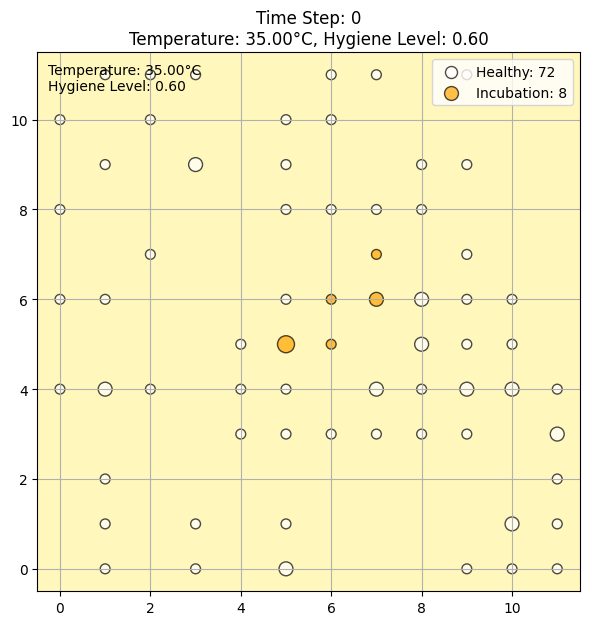

Displaying image for Time Step: 0


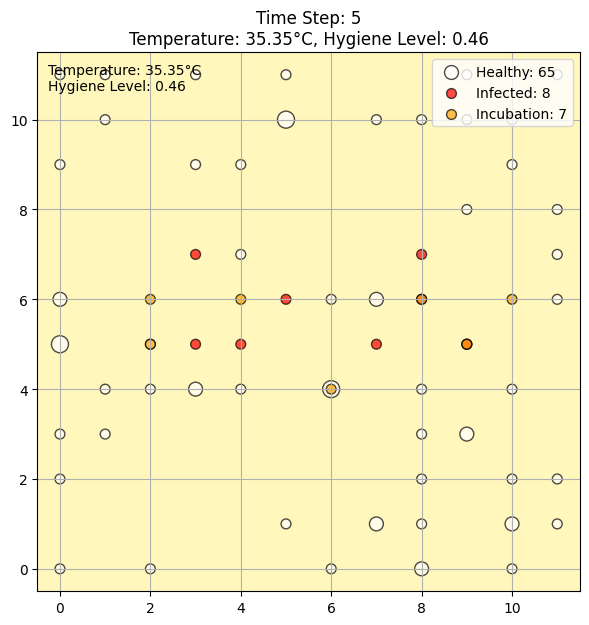

Displaying image for Time Step: 5


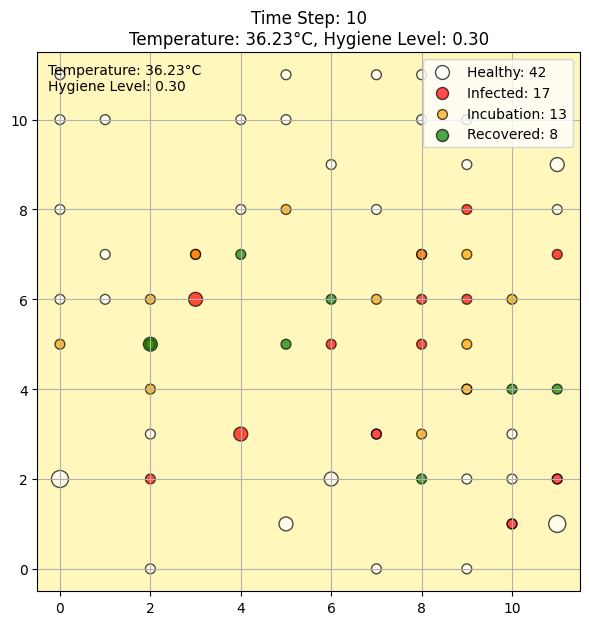

Displaying image for Time Step: 10


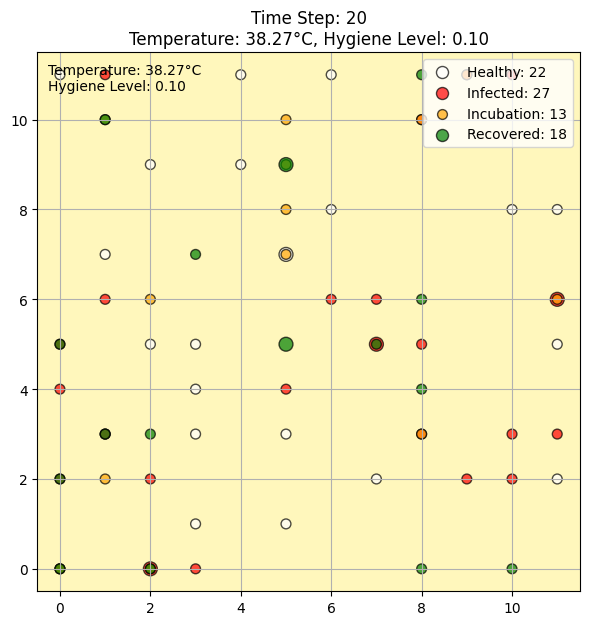

Displaying image for Time Step: 20


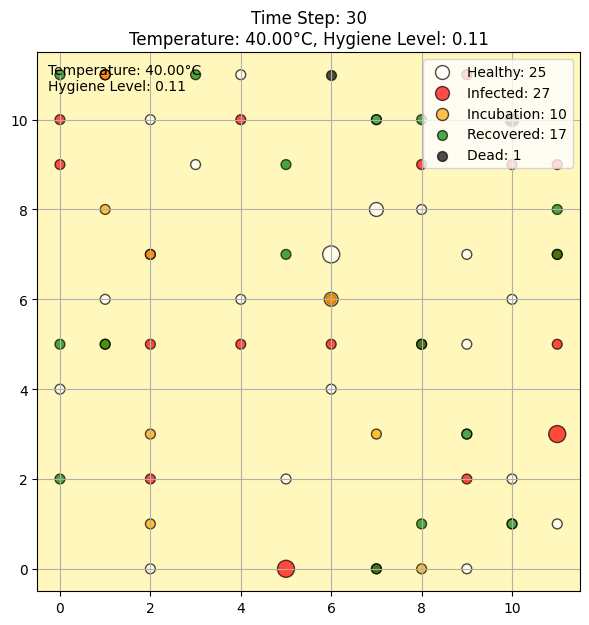

Displaying image for Time Step: 30


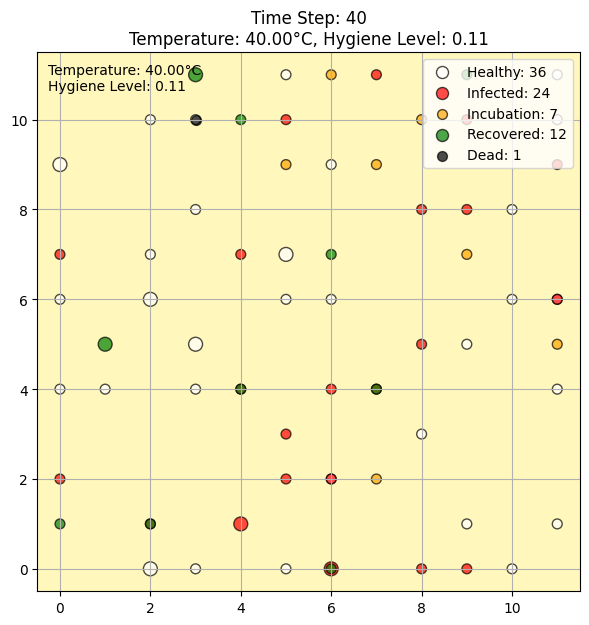

Displaying image for Time Step: 40


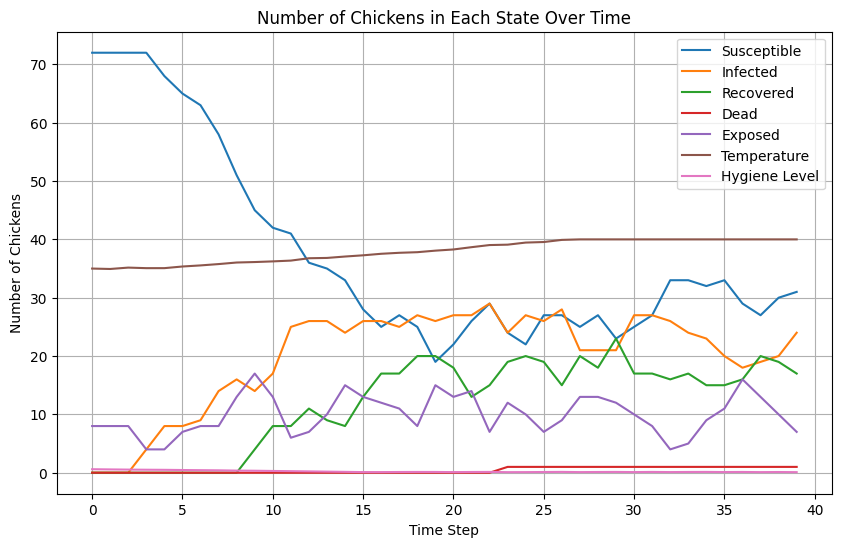

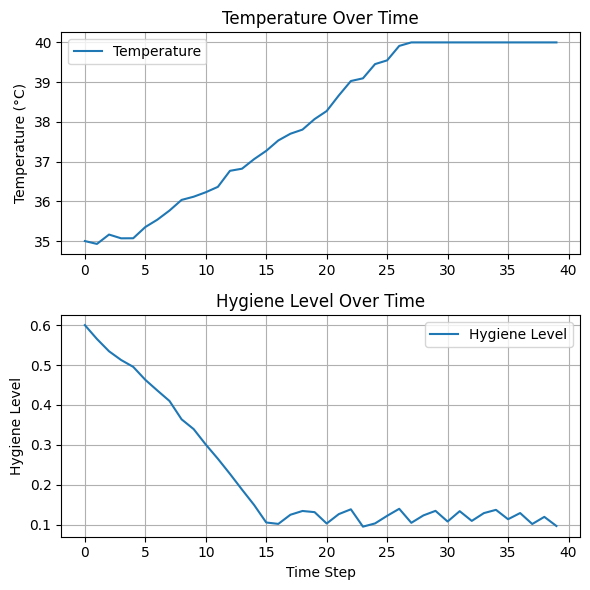

In [8]:
# Create a model instance that now includes temperature and health level parameters
model = AvianFluModel(80, 12, 12, initial_infected=8, temperature=35, hygiene_level=0.6)

# Generate animations and save images for specific time steps
animation, saved_figures = animate_chicken_states(model, total_steps=41)

# Show animation
display(animation)

# Display saved still images
for step, fig_data in saved_figures.items():
    fig = pickle.loads(fig_data)
    display(fig)
    plt.close(fig)
    print(f"Displaying image for Time Step: {step}")

# Displays the number of chickens in different states at each time step, as well as environmental parameters
plot_state_counts_over_time(model)

# Displays changes in environmental parameters over time
plot_environmental_factors(model)